<h1><center>Product Supermarket Sales Prediction</center></h1>

In [349]:
!pip freeze > requirements.txt

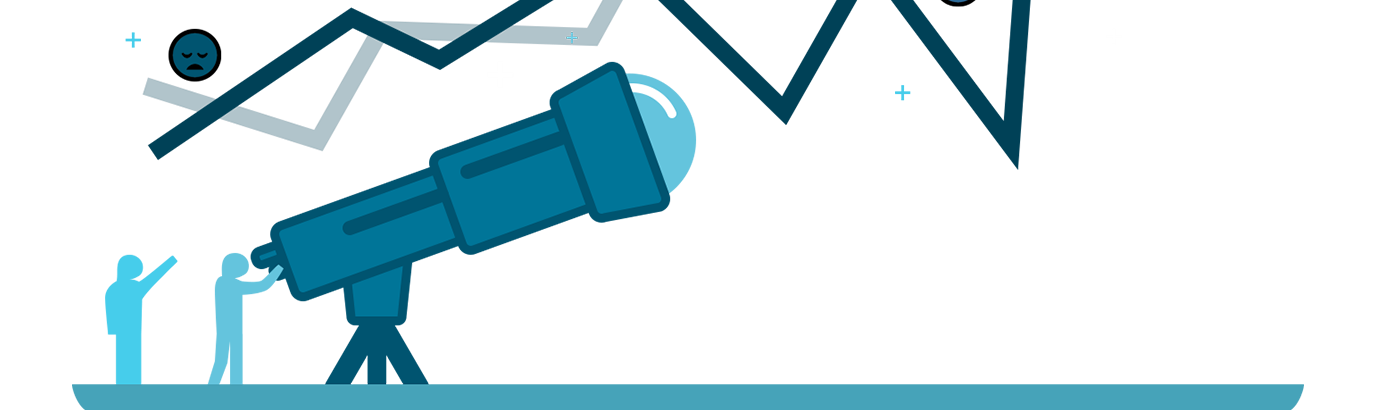

# Abstract

One stage of business life cycle that requires strategic and careful measures is the growth stage. Growth stage comes after the Business has been launched and part of a business growth  can be expansion into more locations. 

It however requires proper and critical analysis to know what location and product type is best for a specific location. For example, a tin of milk which sells for N100 in one supermarket branch may also be sold at N110 at another supermarket within the same chain of supermarkets. Hence, there's a need to understand what type of product, market clusters and supermarket type (location, age, size) will give more margin as business is expanded to more locations.

In this analysis, a predictive mode is developed using machine learning algorithms to improve and accurately forecasts product sales. The proposed model is especially targeted to identify key characteristics of products and supermarkets driving sales so as to be better informed on an optimal template for expansion of Chuwkwudi Supermarket to other states in Nigeria. The model is not intended to change current subjective forecasting methods. A model based on real supermarket store's data is developed in order to validate the use of the various machine learning algorithms


# Introduction
This is an in house kaggle competition organized by **AI+ OAU** where the task is to
predict product supermarket sales to help  identify key characteristics of products and supermarkets driving sales so as to be better informed on an optimal template for expansion of Chukwudi Supermarket to other states in Nigeria.

For this particular problem, I have analyzed the data as a supervised learning problem. In order to
forecasts the sales, I have compared different regression models like Linear Regression, Decision Tree,
ExtraTreeRegressor, Gradient Boosting, Random Forest, XgBoost and Neural Network.

The data comes in the shape of multiple files BUT to demonstrate my SQL proficiency had to load the data into a MySQL database. First, the train table essentially contains the sales by supermarket, product and so on. The test table contains the same features without the product supermarket sales information, which I am tasked to predict. 

#  Data Sources
The data has earlier said comes in the shape of multiple files BUT to demonstrate my SQL proficiency had to load the data into a MySQL database. 
The file containing the mysql scripts that created the database and the data is saved as `chukwudi_supermarket.sql` in the `db and data scripts` folder.
The database contain the following tables:
- `train` contains the sales by supermarket, product and so on.
- `test` contains the same features as train but without the product supermarket sales information
- `sample_submission` contains Supermarket id and dummy product supermarket sales values. This serve as a submission template

In [345]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as sm
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from sklearn.metrics import mean_squared_error, make_scorer
%matplotlib inline

In [321]:
host="localhost"
user="root"
password="delelinus"
database="chukwudi_supermarket"
port = 3306

# create engine
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}', echo=False)

# read in the data
df = pd.read_sql_table(table_name= "train", con= engine)
df2 = pd.read_sql_table(table_name= "test", con= engine)
sample_submission = pd.read_sql_table(table_name= "sample_submission", con= engine)


# close engine
engine.dispose()

In [4]:
def df_report(df):
    """This gives quick report about the missing values, unique numbers and datatypes.
    The argument is the DataFram
    """
    n_missing = (df.isnull().sum()/df.isnull().count() * 100).sort_values(ascending=False)
    n_unique = df.nunique()
    D_types = df.dtypes
    report = pd.concat([n_missing,n_unique,D_types],axis=1 ,keys= ["%_missing", "no_unique", "D_types"])
    return display(report)

In [5]:
# show training data
df.head()

,Product_Identifier,Supermarket_Identifier,Product_Supermarket_Identifier,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket_Opening_Year,Supermarket _Size,Supermarket_Location_Type,Supermarket_Type,Product_Supermarket_Sales
0,DRB24,CHUKWUDI017,DRB24_CHUKWUDI017,8.785,Low Fat,0.020694,Soft Drinks,382.91,2014,None,Cluster 2,Supermarket Type1,4633.97
1,FDR31,CHUKWUDI019,FDR31_CHUKWUDI019,NaN,Normal Fat,0.086078,Fruits and Vegetables,359.53,1992,Small,Cluster 1,Grocery Store,729.05
2,FDP16,CHUKWUDI017,FDP16_CHUKWUDI017,18.600,Low Fat,0.039517,Frozen Foods,609.20,2014,None,Cluster 2,Supermarket Type1,14740.81
3,FDY16,CHUKWUDI027,FDY16_CHUKWUDI027,NaN,Normal Fat,0.091780,Frozen Foods,456.32,1992,Medium,Cluster 3,Supermarket Type3,16137.33
4,FDY48,CHUKWUDI046,FDY48_CHUKWUDI046,14.000,Low Fat,0.023735,Baking Goods,258.08,2004,Small,Cluster 1,Supermarket Type1,4613.99


In [6]:
df_report(df)

,%_missing,no_unique,D_types
Supermarket _Size,30.090861,3,object
Product_Weight,16.060930,389,float64
Product_Identifier,0.000000,1367,object
Supermarket_Identifier,0.000000,10,object
Product_Supermarket_Identifier,0.000000,3742,object
Product_Fat_Content,0.000000,3,object
Product_Shelf_Visibility,0.000000,3481,float64
Product_Type,0.000000,16,object
Product_Price,0.000000,2866,float64
Supermarket_Opening_Year,0.000000,9,int64


In [7]:
df_report(df2)

,%_missing,no_unique,D_types
Supermarket _Size,25.961538,3,object
Product_Weight,16.105769,289,float64
Product_Identifier,0.000000,815,object
Supermarket_Identifier,0.000000,10,object
Product_Supermarket_Identifier,0.000000,1248,object
Product_Fat_Content,0.000000,3,object
Product_Shelf_Visibility,0.000000,1176,float64
Product_Type,0.000000,16,object
Product_Price,0.000000,1118,float64
Supermarket_Opening_Year,0.000000,9,int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3742 entries, 0 to 3741
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Product_Identifier              3742 non-null   object 
 1   Supermarket_Identifier          3742 non-null   object 
 2   Product_Supermarket_Identifier  3742 non-null   object 
 3   Product_Weight                  3141 non-null   float64
 4   Product_Fat_Content             3742 non-null   object 
 5   Product_Shelf_Visibility        3742 non-null   float64
 6   Product_Type                    3742 non-null   object 
 7   Product_Price                   3742 non-null   float64
 8   Supermarket_Opening_Year        3742 non-null   int64  
 9   Supermarket _Size               2616 non-null   object 
 10  Supermarket_Location_Type       3742 non-null   object 
 11  Supermarket_Type                3742 non-null   object 
 12  Product_Supermarket_Sales       37

In [9]:
df.describe(include='all')

,Product_Identifier,Supermarket_Identifier,Product_Supermarket_Identifier,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket_Opening_Year,Supermarket _Size,Supermarket_Location_Type,Supermarket_Type,Product_Supermarket_Sales
count,3742,3742,3742,3141.000000,3742,3742.000000,3742,3742.000000,3742.000000,2616,3742,3742,3742.000000
unique,1367,10,3742,NaN,3,NaN,16,NaN,NaN,3,3,4,NaN
top,NCL31,CHUKWUDI017,DRB24_CHUKWUDI017,NaN,Low Fat,NaN,Snack Foods,NaN,NaN,Medium,Cluster 3,Supermarket Type1,NaN
freq,9,461,1,NaN,2272,NaN,563,NaN,NaN,1155,1438,2495,NaN
mean,NaN,NaN,NaN,12.870640,NaN,0.066613,NaN,391.815315,2004.778461,NaN,NaN,NaN,6103.735353
std,NaN,NaN,NaN,4.730432,NaN,0.052951,NaN,120.204222,8.276712,NaN,NaN,NaN,4456.169125
min,NaN,NaN,NaN,4.555000,NaN,0.000000,NaN,78.730000,1992.000000,NaN,NaN,NaN,83.230000
25%,NaN,NaN,NaN,8.630000,NaN,0.026971,NaN,308.392500,1994.000000,NaN,NaN,NaN,2728.120000
50%,NaN,NaN,NaN,12.600000,NaN,0.053517,NaN,393.910000,2006.000000,NaN,NaN,NaN,5374.675000
75%,NaN,NaN,NaN,17.100000,NaN,0.095094,NaN,466.480000,2011.000000,NaN,NaN,NaN,8524.737500


* missing values are represented with `None`

To check the mode of the supermarket size values `df['Supermarket _Size'].value_counts().idxmax()`

However, the basuc statistical description showed the most frequent supermarket size to be Medium sized supermarkets

### Handling missing values

Since values are missing `Supermarket _Size` and `Product_Weight`:
* check to see if there's by chance a supermarket size value for a `Supermarket_Identifier`corresponding to missing values
* check to see if there's by chance a product weight value for a `Product_Identifier`corresponding to missing values

In [10]:
# get supermarket identifiers for missing Supermarket_Sizes
df[df[["Supermarket _Size"]].isnull().any(axis=1)]["Supermarket_Identifier"].unique()

array(['CHUKWUDI017', 'CHUKWUDI045', 'CHUKWUDI010'], dtype=object)

Only three supermarkets have Supermarket size missing. Let's see if there's a case where supermarket size is available for any of these IDs

In [11]:
for supermarket_id in ['CHUKWUDI017', 'CHUKWUDI045', 'CHUKWUDI010']:
#     print(df.loc[df[["Supermarket _Size"]].notnull().any(axis=1) & df["Supermarket_Identifier"]==supermarket_id])
    print(df.loc[df["Supermarket_Identifier"]==supermarket_id]["Supermarket _Size"].unique())

[None]
[None]
[None]


* Either for the training set or test set, there are no Supermarket Size values for 'CHUKWUDI017', 'CHUKWUDI045' and 'CHUKWUDI010'

In [12]:
# get product and supermarket identifiers for missing Product_Weight
df[df[["Product_Weight"]].isnull().any(axis=1)][["Supermarket_Identifier","Product_Identifier"]].sort_values("Product_Identifier")

,Supermarket_Identifier,Product_Identifier
2977,CHUKWUDI019,DRA24
1502,CHUKWUDI027,DRA24
190,CHUKWUDI019,DRA59
345,CHUKWUDI027,DRA59
862,CHUKWUDI027,DRB01
...,...,...
3238,CHUKWUDI027,NCX42
3392,CHUKWUDI027,NCY54
2154,CHUKWUDI027,NCZ53
1743,CHUKWUDI019,NCZ54


In [13]:
df.loc[df["Product_Identifier"]=='DRA24']

,Product_Identifier,Supermarket_Identifier,Product_Supermarket_Identifier,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket_Opening_Year,Supermarket _Size,Supermarket_Location_Type,Supermarket_Type,Product_Supermarket_Sales
56,DRA24,CHUKWUDI017,DRA24_CHUKWUDI017,19.35,Normal Fat,0.040154,Soft Drinks,411.72,2014,None,Cluster 2,Supermarket Type1,2866.27
518,DRA24,CHUKWUDI010,DRA24_CHUKWUDI010,19.35,Normal Fat,0.066832,Soft Drinks,409.72,2005,None,Cluster 3,Grocery Store,818.93
1502,DRA24,CHUKWUDI027,DRA24_CHUKWUDI027,NaN,Normal Fat,0.039735,Soft Drinks,414.47,1992,Medium,Cluster 3,Supermarket Type3,12284.01
2977,DRA24,CHUKWUDI019,DRA24_CHUKWUDI019,NaN,Normal Fat,0.069909,Soft Drinks,408.22,1992,Small,Cluster 1,Grocery Store,1228.40
3374,DRA24,CHUKWUDI035,DRA24_CHUKWUDI035,19.35,Normal Fat,0.039921,Soft Drinks,408.47,2011,Small,Cluster 2,Supermarket Type1,8598.81
3610,DRA24,CHUKWUDI013,DRA24_CHUKWUDI013,19.35,Normal Fat,0.039895,Soft Drinks,406.22,1994,High,Cluster 3,Supermarket Type1,11055.61


* Good. We will have to fill missing Product weight values with values corresponding to the particular product ID with the missing proudct weight

In [14]:
for i in df[df[["Product_Weight"]].isnull().any(axis=1)]['Product_Identifier'].unique():
#     print(df.loc[df[["Product_Weight"]].notnull().all(axis=1) & df["Product_Identifier"]==i])
    print(df.loc[df["Product_Identifier"]==i]["Product_Weight"].unique())

[ nan 6.46]
[  nan 18.35]
[ nan 20.5]
[ nan 7.93]
[ nan 14.5]
[ nan 5.46]
[nan 11.]
[  nan 6.655]
[ nan 6.69]
[  nan 12.15]
[ nan 19.7]
[  nan 20.25]
[  nan 19.35]
[ nan 12.6]
[  nan 18.25]
[  nan 13.65]
[ nan 8.42]
[nan 17.]
[7.865   nan]
[  nan 15.35]
[  nan 19.35]
[ nan 12.6]
[ nan 16.7]
[  nan 9.695]
[  nan 20.25]
[nan  9.]
[  nan 13.15]
[ nan 8.63]
[  nan 16.25]
[ nan 8.27]
[ nan 18.2]
[  nan 18.35]
[nan 6.3]
[ nan 15.2]
[ nan 15.5]
[9.06  nan]
[ nan 13.5]
[ nan 16.1]
[7.315   nan]
[ nan 19.6]
[5.655   nan]
[ nan 13.5]
[ nan 17.6]
[ nan 7.47]
[nan 15.]
[nan 18.]
[nan]
[9.695   nan]
[7.39  nan]
[ nan 14.8]
[  nan 16.35]
[nan 5.4]
[ nan 20.2]
[18.35   nan]
[15.85   nan]
[ nan 13.1]
[ nan 19.7]
[ nan 10.5]
[13.1  nan]
[  nan 12.65]
[  nan 18.75]
[  nan 15.85]
[18.85   nan]
[ nan 12.8]
[ nan 20.2]
[  nan 11.35]
[  nan 20.25]
[ nan 14.5]
[21.2  nan]
[11.15   nan]
[12.6  nan]
[ nan 20.1]
[10.195    nan]
[nan 9.3]
[4.61  nan]
[ nan 20.2]
[  nan 20.35]
[ nan 17.6]
[ nan 11.6]
[nan 13.]
[1

#### treat the missing values
`Product_Weight`: 
* sort data frame by `Product_Identifier`,`Product_Weight` (makes non-NaN entries appear first), then forward fill the Product Weight to have the values copied to the NaN entries

`Supermarket _Size`:
* try replacing with mode or
* try replacing with a unique value (identify it as missing value)

In [15]:
df.head(6)

,Product_Identifier,Supermarket_Identifier,Product_Supermarket_Identifier,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket_Opening_Year,Supermarket _Size,Supermarket_Location_Type,Supermarket_Type,Product_Supermarket_Sales
0,DRB24,CHUKWUDI017,DRB24_CHUKWUDI017,8.785,Low Fat,0.020694,Soft Drinks,382.91,2014,None,Cluster 2,Supermarket Type1,4633.97
1,FDR31,CHUKWUDI019,FDR31_CHUKWUDI019,NaN,Normal Fat,0.086078,Fruits and Vegetables,359.53,1992,Small,Cluster 1,Grocery Store,729.05
2,FDP16,CHUKWUDI017,FDP16_CHUKWUDI017,18.600,Low Fat,0.039517,Frozen Foods,609.20,2014,None,Cluster 2,Supermarket Type1,14740.81
3,FDY16,CHUKWUDI027,FDY16_CHUKWUDI027,NaN,Normal Fat,0.091780,Frozen Foods,456.32,1992,Medium,Cluster 3,Supermarket Type3,16137.33
4,FDY48,CHUKWUDI046,FDY48_CHUKWUDI046,14.000,Low Fat,0.023735,Baking Goods,258.08,2004,Small,Cluster 1,Supermarket Type1,4613.99
5,FDK45,CHUKWUDI046,FDK45_CHUKWUDI046,11.650,Ultra Low fat,0.033858,Seafood,283.47,2004,Small,Cluster 1,Supermarket Type1,6508.20


In [16]:
df.Product_Weight = df.sort_values(['Product_Identifier','Product_Weight']).Product_Weight.ffill()
df2.Product_Weight = df.sort_values(['Product_Identifier','Product_Weight']).Product_Weight.ffill()

In [17]:
df.head(6)

,Product_Identifier,Supermarket_Identifier,Product_Supermarket_Identifier,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket_Opening_Year,Supermarket _Size,Supermarket_Location_Type,Supermarket_Type,Product_Supermarket_Sales
0,DRB24,CHUKWUDI017,DRB24_CHUKWUDI017,8.785,Low Fat,0.020694,Soft Drinks,382.91,2014,None,Cluster 2,Supermarket Type1,4633.97
1,FDR31,CHUKWUDI019,FDR31_CHUKWUDI019,6.460,Normal Fat,0.086078,Fruits and Vegetables,359.53,1992,Small,Cluster 1,Grocery Store,729.05
2,FDP16,CHUKWUDI017,FDP16_CHUKWUDI017,18.600,Low Fat,0.039517,Frozen Foods,609.20,2014,None,Cluster 2,Supermarket Type1,14740.81
3,FDY16,CHUKWUDI027,FDY16_CHUKWUDI027,18.350,Normal Fat,0.091780,Frozen Foods,456.32,1992,Medium,Cluster 3,Supermarket Type3,16137.33
4,FDY48,CHUKWUDI046,FDY48_CHUKWUDI046,14.000,Low Fat,0.023735,Baking Goods,258.08,2004,Small,Cluster 1,Supermarket Type1,4613.99
5,FDK45,CHUKWUDI046,FDK45_CHUKWUDI046,11.650,Ultra Low fat,0.033858,Seafood,283.47,2004,Small,Cluster 1,Supermarket Type1,6508.20


In [18]:
#replace the missing 'Supermarket_Size' values by the most frequent 
df["Supermarket _Size"].replace(np.nan, "Medium", inplace=True)
df2["Supermarket _Size"].replace(np.nan, "Medium", inplace=True)

In [19]:
df_report(df)

,%_missing,no_unique,D_types
Product_Identifier,0.0,1367,object
Supermarket_Identifier,0.0,10,object
Product_Supermarket_Identifier,0.0,3742,object
Product_Weight,0.0,389,float64
Product_Fat_Content,0.0,3,object
Product_Shelf_Visibility,0.0,3481,float64
Product_Type,0.0,16,object
Product_Price,0.0,2866,float64
Supermarket_Opening_Year,0.0,9,int64
Supermarket _Size,0.0,3,object


In [20]:
df_report(df2)

,%_missing,no_unique,D_types
Product_Identifier,0.0,815,object
Supermarket_Identifier,0.0,10,object
Product_Supermarket_Identifier,0.0,1248,object
Product_Weight,0.0,301,float64
Product_Fat_Content,0.0,3,object
Product_Shelf_Visibility,0.0,1176,float64
Product_Type,0.0,16,object
Product_Price,0.0,1118,float64
Supermarket_Opening_Year,0.0,9,int64
Supermarket _Size,0.0,3,object


# Exploratory Analysis

## Univariate 

In [21]:
redundant_col = ['Product_Identifier','Supermarket_Identifier','Product_Supermarket_Identifier']

def object_type_distribution_plot(df):
    """ This gives the distribution of the variables with the object data type
    """
    for var in df.drop(redundant_col, axis=1).columns:
        if df[var].dtype == "object":
            #print(df[var].value_counts().name)
            #print(df[var].value_counts())
            print(df[var].describe(include='object'))
            #without the plt.figure line, it won't bring out all the plots and only show for the last plot even wrongly
            plt.figure(figsize=(10,5))
            ax = sns.countplot(data=df, x=var)
            #rotate label if too long
            plt.xticks(rotation=90)
            plt.show()

            #plt.tight_layout()


def numeric_type_distribution_plot(df):
    for var in df.drop(redundant_col, axis=1).columns:
        if df[var].dtype != "object":
            print(df[var].describe())
            #without the plt.figure line, it won't bring out all the plots and only show for the last plot even wrongly
            plt.figure(figsize=(10,5))
            ax = sns.distplot(df[var])
            #rotate label if too long
            plt.xticks(rotation=90)
            plt.show()

#             plt.tight_layout()

count        3742
unique          3
top       Low Fat
freq         2272
Name: Product_Fat_Content, dtype: object


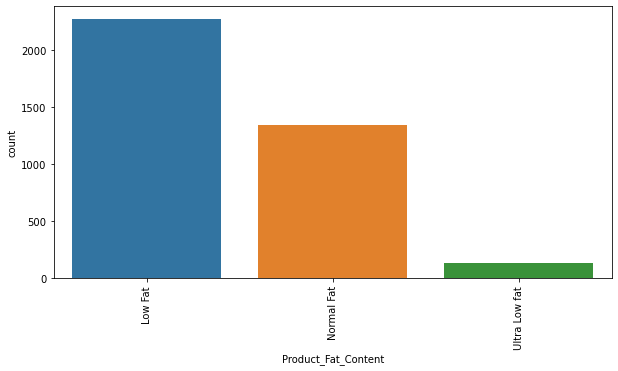

count            3742
unique             16
top       Snack Foods
freq              563
Name: Product_Type, dtype: object


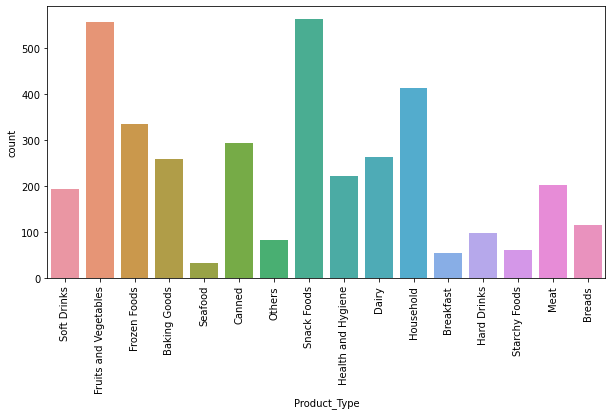

count       3742
unique         3
top       Medium
freq        2281
Name: Supermarket _Size, dtype: object


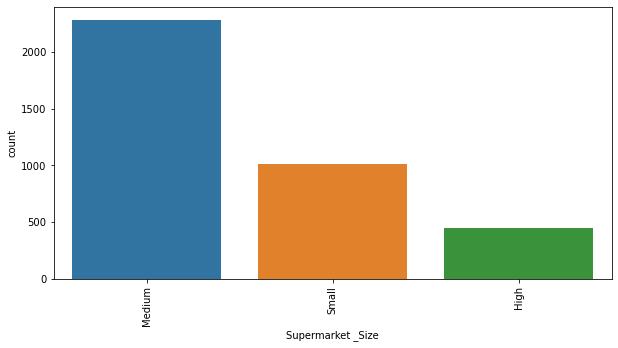

count          3742
unique            3
top       Cluster 3
freq           1438
Name: Supermarket_Location_Type, dtype: object


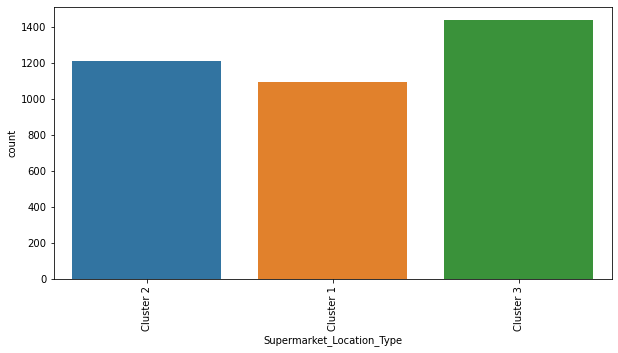

count                  3742
unique                    4
top       Supermarket Type1
freq                   2495
Name: Supermarket_Type, dtype: object


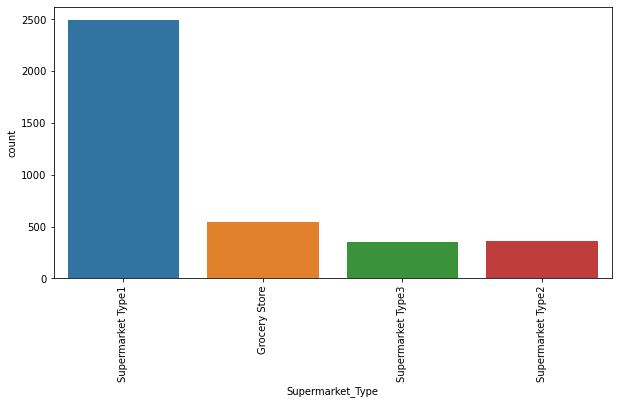

In [22]:
object_type_distribution_plot(df)

count    3742.000000
mean       12.900290
std         4.716667
min         4.555000
25%         8.710000
50%        12.600000
75%        17.200000
max        21.350000
Name: Product_Weight, dtype: float64


C:\Users\DeleLinus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


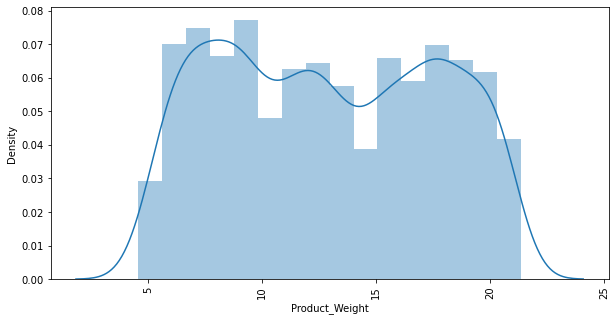

count    3742.000000
mean        0.066613
std         0.052951
min         0.000000
25%         0.026971
50%         0.053517
75%         0.095094
max         0.328391
Name: Product_Shelf_Visibility, dtype: float64


C:\Users\DeleLinus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


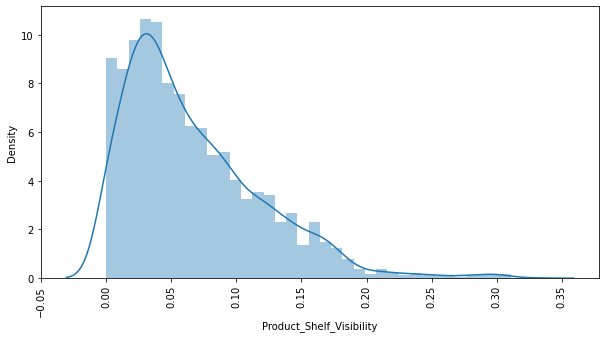

count    3742.000000
mean      391.815315
std       120.204222
min        78.730000
25%       308.392500
50%       393.910000
75%       466.480000
max       667.220000
Name: Product_Price, dtype: float64


C:\Users\DeleLinus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


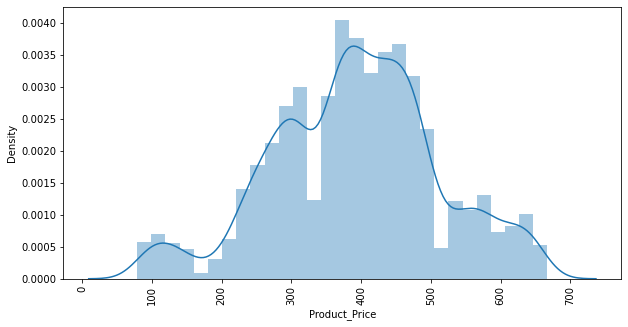

C:\Users\DeleLinus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    3742.000000
mean     2004.778461
std         8.276712
min      1992.000000
25%      1994.000000
50%      2006.000000
75%      2011.000000
max      2016.000000
Name: Supermarket_Opening_Year, dtype: float64


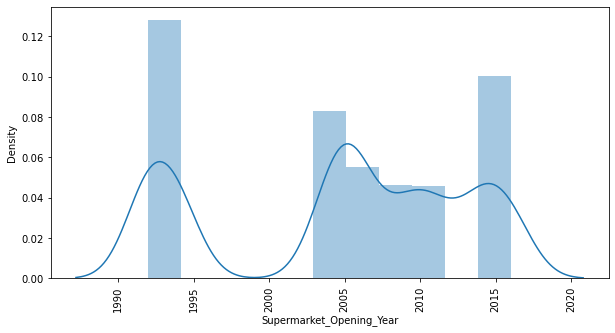

C:\Users\DeleLinus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count     3742.000000
mean      6103.735353
std       4456.169125
min         83.230000
25%       2728.120000
50%       5374.675000
75%       8524.737500
max      28612.760000
Name: Product_Supermarket_Sales, dtype: float64


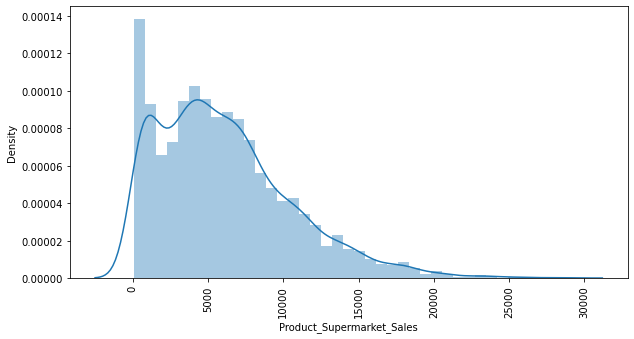

In [23]:
numeric_type_distribution_plot(df)

* Product shelf visibility isn't normally distributed, let's see how it looks when log-transformed

C:\Users\DeleLinus\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\DeleLinus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


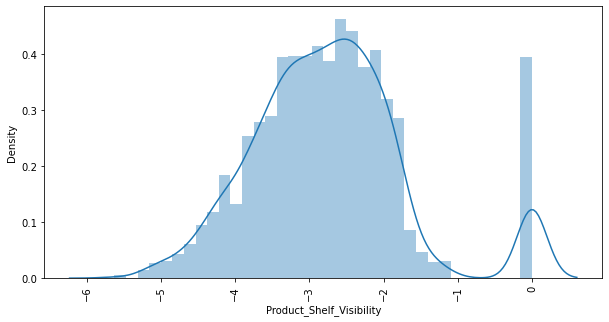

In [24]:
plt.figure(figsize=(10,5))
sns.distplot(np.log(df["Product_Shelf_Visibility"]).replace([np.inf,-np.inf],0))
#rotate label if too long
plt.xticks(rotation=90)
plt.show()

* log transformation resultrd in many infinity values and hence would not be appropriate for treating the skewness

In [25]:
np.log(df["Product_Shelf_Visibility"]).replace([np.inf,-np.inf],np.nan).isnull().sum()

C:\Users\DeleLinus\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


231

## Multivariate

**product that gives a better margin at specific stores**

In [26]:
grpd_1 = df[['Product_Type','Supermarket_Identifier','Product_Supermarket_Sales', "Product_Price"]].copy()
grpd_1["Profits"] = grpd_1['Product_Supermarket_Sales'] - grpd_1['Product_Price']

# grpd_1.drop(columns=['Product_Supermarket_Sales', "Product_Price"], inplace=True)

In [27]:
grpd_1=grpd_1.groupby(['Product_Type','Supermarket_Identifier'],as_index=False).mean()
grpd_1 = grpd_1.sort_values(['Product_Type','Profits'], ascending=False)

grpd_1.head()

,Product_Type,Supermarket_Identifier,Product_Supermarket_Sales,Product_Price,Profits
155,Starchy Foods,CHUKWUDI027,10260.930000,491.717143,9769.212857
157,Starchy Foods,CHUKWUDI045,10196.014286,530.237143,9665.777143
156,Starchy Foods,CHUKWUDI035,9732.888889,487.145556,9245.743333
152,Starchy Foods,CHUKWUDI017,8741.955000,508.576250,8233.378750
158,Starchy Foods,CHUKWUDI046,7449.885000,396.960000,7052.925000


In [28]:
grouped_pivot = grpd_1.pivot(index='Product_Type',columns='Supermarket_Identifier',values="Profits" )
grouped_pivot

Supermarket_Identifier,CHUKWUDI010,CHUKWUDI013,CHUKWUDI017,CHUKWUDI018,CHUKWUDI019,CHUKWUDI027,CHUKWUDI035,CHUKWUDI045,CHUKWUDI046,CHUKWUDI049
Product_Type,,,,,,,,,,
Baking Goods,342.953913,3361.910513,6142.820968,5569.298800,606.238333,10876.145238,7467.126500,7503.396087,5092.351667,6269.787586
Breads,462.541000,3473.561429,7151.914167,5288.007692,524.851250,11210.451818,7247.884167,6182.535833,5738.472222,5791.264286
Breakfast,383.732500,2680.308000,5212.357500,4999.657500,889.078000,14364.006000,8987.905000,6237.188333,4426.235000,6097.457143
Canned,258.170000,3374.157879,7909.467500,4621.122759,934.246667,12457.702143,7641.667714,7281.329375,6223.914062,5552.057429
Dairy,206.923333,3016.171935,7502.210303,4791.127500,554.982083,13083.603571,8826.983600,6630.504839,4620.380435,5082.457742
Frozen Foods,309.128333,3542.243137,7392.632955,5067.853871,771.871000,12420.451667,7576.304667,7221.765484,5559.290000,5045.170345
Fruits and Vegetables,321.620250,3864.213636,7447.375077,5412.672759,525.432059,13650.385882,6888.145185,7232.594444,5266.057255,6452.157297
Hard Drinks,128.511429,3741.352222,7246.401667,3865.574000,446.806667,10435.394000,6842.853333,6349.703846,5956.172500,6052.948750
Health and Hygiene,439.697895,3668.942187,5762.615517,4103.040625,930.330000,10724.130000,7280.343000,6476.720500,5639.113333,5630.083333


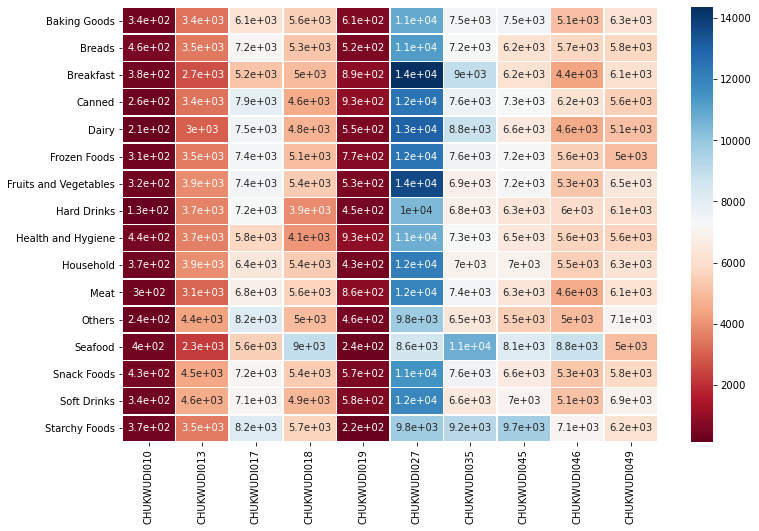

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(grouped_pivot, annot= True, ax=ax, linewidths=0.6, cmap='RdBu')

#move ticks and labels to the center
ax.set_xticks(np.arange(grouped_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(grouped_pivot.shape[0]) + 0.5, minor=False)

#insert labels
# ax.set_xticklabels(row_labels, minor=False)
# ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

# don't show labels
plt.xlabel("")
plt.ylabel("")

plt.show()

Product that gives a better margin at specific stores are as shown in the heatmap above:
* Seafood product gave the best margin at Chukwudi018, Chukwudi035 and Chukwudi046

**Supermarket Type analysis**

In [30]:
grouped_2=df[['Supermarket_Type', 'Product_Supermarket_Sales']]
grpd_2=grouped_2.groupby(['Supermarket_Type'],as_index=False).mean()
grpd_2

,Supermarket_Type,Product_Supermarket_Sales
0,Grocery Store,821.426611
1,Supermarket Type1,6434.596537
2,Supermarket Type2,5588.015335
3,Supermarket Type3,12541.373382


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Supermarket Type1'),
  Text(1, 0, 'Grocery Store'),
  Text(2, 0, 'Supermarket Type3'),
  Text(3, 0, 'Supermarket Type2')])

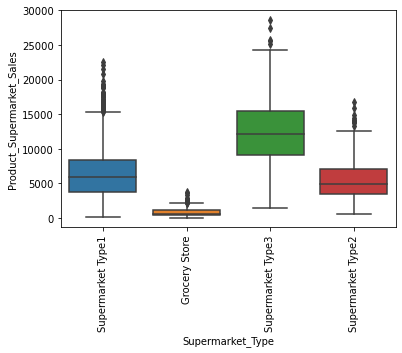

In [31]:
sns.boxplot(x="Supermarket_Type", y="Product_Supermarket_Sales", data=df)
#rotate label if too long
plt.xticks(rotation=90)

In [32]:
grpd_2=grouped_2.groupby(['Supermarket_Type'],as_index=False)
f_val, p_val = stats.f_oneway(grpd_2.get_group('Supermarket Type1')['Product_Supermarket_Sales'], grpd_2.get_group('Supermarket Type2')['Product_Supermarket_Sales'], grpd_2.get_group('Supermarket Type3')['Product_Supermarket_Sales'], grpd_2.get_group('Grocery Store')['Product_Supermarket_Sales'])  
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 837.407760674732 , P = 0.0


* We see that the distributions of sales between the different supermarket-type categories are distinct, and enough to take Supermarket Type as a potential good predictor of sales price

Let's examine Supermarket_Location and Supermarket sales

**Supermarket_Location_Type analysis**

In [33]:
grouped_3=df[['Supermarket_Location_Type', 'Product_Supermarket_Sales']]
grpd_3=grouped_3.groupby(['Supermarket_Location_Type'],as_index=False).mean()
grpd_3

,Supermarket_Location_Type,Product_Supermarket_Sales
0,Cluster 1,4907.270494
1,Cluster 2,7581.598620
2,Cluster 3,5770.437719


In [34]:
df['Supermarket_Location_Type'].value_counts()

Cluster 3    1438
Cluster 2    1210
Cluster 1    1094
Name: Supermarket_Location_Type, dtype: int64

<AxesSubplot:xlabel='Supermarket_Location_Type', ylabel='Product_Supermarket_Sales'>

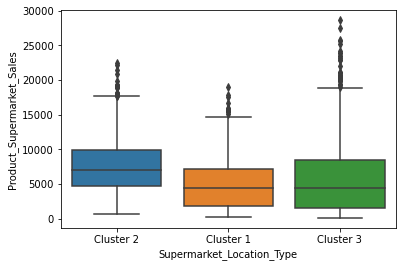

In [35]:
sns.boxplot(x="Supermarket_Location_Type", y="Product_Supermarket_Sales", data=df)

* We see that the distributions of sales between the different Supermarket-Location categories have a significant overlap, and so Supermarket-Location would not be a good predictor of sales.

In [36]:
grpd_3=grouped_3.groupby(['Supermarket_Location_Type'],as_index=False)
f_val, p_val = stats.f_oneway(grpd_3.get_group('Cluster 1')['Product_Supermarket_Sales'], grpd_3.get_group('Cluster 2')['Product_Supermarket_Sales'], grpd_3.get_group('Cluster 3')['Product_Supermarket_Sales'])  
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 116.808702799811 , P = 6.199756735425813e-50


* The Anova result says otherwise from what the Boxplot suggests. I might have to consider Supermarket location as a potential predictor

**Product_Fat_Content analysis**

In [37]:
df['Product_Fat_Content'].value_counts()

Low Fat          2272
Normal Fat       1341
Ultra Low fat     129
Name: Product_Fat_Content, dtype: int64

In [38]:
grouped_4=df[['Product_Fat_Content', 'Product_Supermarket_Sales']]
grpd_4=grouped_4.groupby(['Product_Fat_Content'],as_index=False).mean()
grpd_4

,Product_Fat_Content,Product_Supermarket_Sales
0,Low Fat,6038.504696
1,Normal Fat,6287.411447
2,Ultra Low fat,5343.226899


<AxesSubplot:xlabel='Product_Fat_Content', ylabel='Product_Supermarket_Sales'>

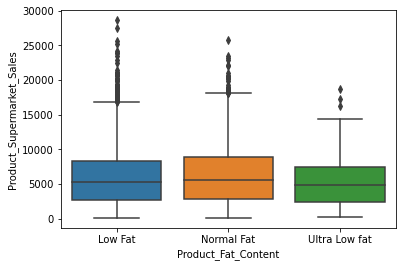

In [39]:
sns.boxplot(x='Product_Fat_Content', y='Product_Supermarket_Sales', data=df)

In [40]:
grpd_4=grouped_4.groupby(['Product_Fat_Content'],as_index=False)
f_val, p_val = stats.f_oneway(grpd_4.get_group('Low Fat')['Product_Supermarket_Sales'], grpd_4.get_group('Normal Fat')['Product_Supermarket_Sales'], grpd_4.get_group('Ultra Low fat')['Product_Supermarket_Sales'])  
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 3.265164001492282 , P = 0.03829959562702081


* In the boxplot, we see that the distribution of sales between the different product-fat-content categories have a significant overlap and as such Product-fat-content could not be a predictor of sales.

* With low F test score showing a weak correlation and a P value of almost 0 implying almost certain statistical significance, it further confirm that Product-fat-content cannot be a predictor of supermarket sales

**supermarket_size analysis**

In [41]:
df['Supermarket _Size'].value_counts()

Medium    2281
Small     1015
High       446
Name: Supermarket _Size, dtype: int64

In [42]:
grouped_5=df[['Supermarket _Size', 'Product_Supermarket_Sales']]
grpd_5=grouped_5.groupby(['Supermarket _Size'],as_index=False).mean()
grpd_5

,Supermarket _Size,Product_Supermarket_Sales
0,High,3998.670359
1,Medium,6844.184498
2,Small,5364.715143


<AxesSubplot:xlabel='Supermarket _Size', ylabel='Product_Supermarket_Sales'>

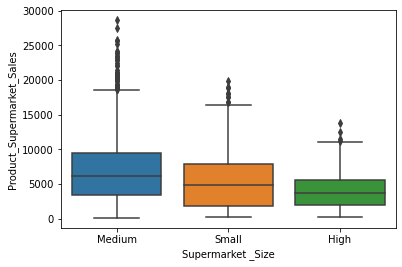

In [43]:
sns.boxplot(x='Supermarket _Size', y='Product_Supermarket_Sales', data=df)

In [44]:
grpd_5=grouped_5.groupby(['Supermarket _Size'],as_index=False)
f_val, p_val = stats.f_oneway(grpd_5.get_group('Medium')['Product_Supermarket_Sales'], grpd_5.get_group('Small')['Product_Supermarket_Sales'],grpd_5.get_group('High')['Product_Supermarket_Sales'])  
print( "ANOVA results: F=", f_val, ", P =", p_val) 

ANOVA results: F= 100.26367160481566 , P = 3.8331989326796805e-43


Here we see that the distribution of sales between the different supermarket size categories differs; as such supermarket-size could potentially be a predictor of supermarket sales.

**Product_Type analysis**

In [45]:
df['Product_Type'].value_counts()

Snack Foods              563
Fruits and Vegetables    556
Household                414
Frozen Foods             334
Canned                   294
Dairy                    263
Baking Goods             259
Health and Hygiene       222
Meat                     202
Soft Drinks              193
Breads                   115
Hard Drinks               97
Others                    82
Starchy Foods             62
Breakfast                 54
Seafood                   32
Name: Product_Type, dtype: int64

In [46]:
grouped_6=df[['Product_Type','Product_Supermarket_Sales']]
grpd_6=grouped_6.groupby(['Product_Type'],as_index=False).mean()
grpd_6

,Product_Type,Product_Supermarket_Sales
0,Baking Goods,5635.721351
1,Breads,5875.077043
2,Breakfast,5867.887222
3,Canned,6392.173197
4,Dairy,6081.969734
5,Frozen Foods,5980.055359
6,Fruits and Vegetables,6429.236259
7,Hard Drinks,6097.784845
8,Health and Hygiene,5476.370586
9,Household,6158.381329


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Starchy Foods'),
  Text(1, 0, 'Soft Drinks'),
  Text(2, 0, 'Snack Foods'),
  Text(3, 0, 'Seafood'),
  Text(4, 0, 'Others'),
  Text(5, 0, 'Meat'),
  Text(6, 0, 'Household'),
  Text(7, 0, 'Health and Hygiene'),
  Text(8, 0, 'Hard Drinks'),
  Text(9, 0, 'Fruits and Vegetables'),
  Text(10, 0, 'Frozen Foods'),
  Text(11, 0, 'Dairy'),
  Text(12, 0, 'Canned'),
  Text(13, 0, 'Breakfast'),
  Text(14, 0, 'Breads'),
  Text(15, 0, 'Baking Goods')])

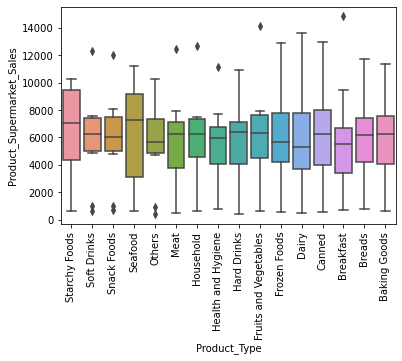

In [47]:
sns.boxplot(x='Product_Type', y='Product_Supermarket_Sales', data=grpd_1)
#rotate label if too long
plt.xticks(rotation=90)

* We see that the distributions of supermarket-sales between the different Product types categories have a significant overlap, and so product-types would not be a good predictor of sales.

In [48]:
grouped_7=df[['Supermarket_Opening_Year','Supermarket_Identifier','Product_Supermarket_Sales']]
grpd_7=grouped_7.groupby(['Supermarket_Opening_Year','Supermarket_Identifier'],as_index=False).mean()
grpd_7.sort_values(['Product_Supermarket_Sales'], ascending=False)

,Supermarket_Opening_Year,Supermarket_Identifier,Product_Supermarket_Sales
1,1992,CHUKWUDI027,12541.373382
7,2011,CHUKWUDI035,7907.270484
8,2014,CHUKWUDI017,7468.619197
6,2009,CHUKWUDI045,7398.398568
5,2006,CHUKWUDI049,6352.267561
3,2004,CHUKWUDI046,5753.361804
9,2016,CHUKWUDI018,5588.015335
2,1994,CHUKWUDI013,3998.670359
0,1992,CHUKWUDI019,1064.223020
4,2005,CHUKWUDI010,606.450625


(0.0, 13146.66742793651)

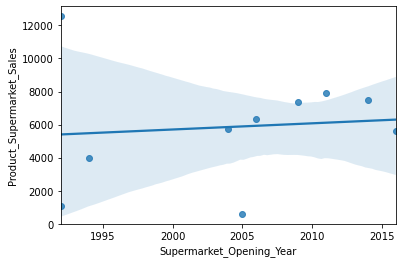

In [49]:
# Engine size as potential predictor variable of price
sns.regplot(x="Supermarket_Opening_Year", y="Product_Supermarket_Sales", data=grpd_7)
plt.ylim(0,)

In [50]:
grpd_7.corr()

,Supermarket_Opening_Year,Product_Supermarket_Sales
Supermarket_Opening_Year,1.000000,0.095753
Product_Supermarket_Sales,0.095753,1.000000


In [51]:
df.corr()

,Product_Weight,Product_Shelf_Visibility,Product_Price,Supermarket_Opening_Year,Product_Supermarket_Sales
Product_Weight,1.000000,-0.015260,0.037564,0.000649,0.015314
Product_Shelf_Visibility,-0.015260,1.000000,-0.028941,-0.084218,-0.161008
Product_Price,0.037564,-0.028941,1.000000,0.161113,0.524002
Supermarket_Opening_Year,0.000649,-0.084218,0.161113,1.000000,0.057508
Product_Supermarket_Sales,0.015314,-0.161008,0.524002,0.057508,1.000000


In [52]:
df.columns

Index(['Product_Identifier', 'Supermarket_Identifier',
       'Product_Supermarket_Identifier', 'Product_Weight',
       'Product_Fat_Content', 'Product_Shelf_Visibility', 'Product_Type',
       'Product_Price', 'Supermarket_Opening_Year', 'Supermarket _Size',
       'Supermarket_Location_Type', 'Supermarket_Type',
       'Product_Supermarket_Sales'],
      dtype='object')

* Opening Year would as well not be a good predictor of sales

## Summary

<p>We now have a better idea of what our data looks like and which variables are important to take into account when predicting the supermarket sales price. We have narrowed it down to the following variables:</p>

Continuous numerical variables:
<ul>
    <li>Product_Weight</li>
    <li>Product_Price</li>
    <li>Product_Shelf_Visibility</li>
</ul>
    
Categorical variables:
<ul>
    <li>Supermarket _Size</li>
    <li>Supermarket_Location_Type</li>
    <li>Supermarket_Type</li>
    <li>Product_Type</li>
</ul>

<p>As we now move into building machine learning models to automate our analysis, feeding the model with variables that meaningfully affect our target variable will improve our model's prediction performance.</p>

# Data Transformation
* Assign dependent and independent variables (drop redundant columns)
* One-hot encode categorical variables
* Do label encoding for hierachical categories
* Normalize the eatures

In [203]:
# label encoding
# X2 = X.copy()

# sm_size_map = {'Small':1, 'Medium':2, 'High':3}
# X2['Supermarket _Size'] = X2['Supermarket _Size'].map(sm_size_map).astype("float")

# sm_loc_map = {'Cluster 1':1, 'Cluster 3':3, 'Cluster 2':2}
# X2['Supermarket_Location_Type'] = X2['Supermarket_Location_Type'].map(sm_loc_map).astype("float")

# sm_type_map = {'Grocery Store':1, 'Supermarket Type2':2, 'Supermarket Type1':3, 'Supermarket Type3':4}
# X2['Supermarket_Type'] = df['Supermarket_Type'].map(sm_type_map).astype("float")




# prod_fat_map = {'Ultra Low fat':1, 'Low Fat':2, 'Normal Fat':3}
# X2['Product_Fat_Content'] = X2['Product_Fat_Content'].map(prod_fat_map)


* model performances were poor with label encoding

In [322]:
# independent features
feature_set = ['Product_Weight', 'Product_Shelf_Visibility', 'Product_Type', 'Product_Price',
               'Supermarket _Size', 'Supermarket_Location_Type', 'Supermarket_Type'] 

X = df.drop(['Product_Identifier','Supermarket_Identifier','Product_Supermarket_Identifier',
           'Product_Fat_Content','Supermarket_Opening_Year','Product_Supermarket_Sales'], axis=1)
# dependent variable
y = df['Product_Supermarket_Sales'].values

In [323]:
X.head()

,Product_Weight,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket _Size,Supermarket_Location_Type,Supermarket_Type
0,8.785,0.020694,Soft Drinks,382.91,None,Cluster 2,Supermarket Type1
1,NaN,0.086078,Fruits and Vegetables,359.53,Small,Cluster 1,Grocery Store
2,18.600,0.039517,Frozen Foods,609.20,None,Cluster 2,Supermarket Type1
3,NaN,0.091780,Frozen Foods,456.32,Medium,Cluster 3,Supermarket Type3
4,14.000,0.023735,Baking Goods,258.08,Small,Cluster 1,Supermarket Type1


In [324]:
df2 = df2.drop(['Product_Identifier','Supermarket_Identifier','Product_Supermarket_Identifier',
                'Product_Fat_Content','Supermarket_Opening_Year'], axis=1)
df2.head()

,Product_Weight,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket _Size,Supermarket_Location_Type,Supermarket_Type
0,18.100,0.178246,Dairy,395.32,Medium,Cluster 1,Supermarket Type1
1,15.250,0.061434,Household,327.49,Medium,Cluster 3,Supermarket Type2
2,8.785,0.020573,Soft Drinks,391.16,Small,Cluster 2,Supermarket Type1
3,12.100,0.080131,Household,427.28,Medium,Cluster 3,Supermarket Type2
4,6.965,0.028710,Household,395.40,None,Cluster 2,Supermarket Type1


In [325]:
X = pd.get_dummies(X)
df2 = pd.get_dummies(df2)
# show
X.head()
df2 .head()

,Product_Weight,Product_Shelf_Visibility,Product_Price,Product_Type_Baking Goods,Product_Type_Breads,Product_Type_Breakfast,Product_Type_Canned,Product_Type_Dairy,Product_Type_Frozen Foods,Product_Type_Fruits and Vegetables,...,Supermarket _Size_High,Supermarket _Size_Medium,Supermarket _Size_Small,Supermarket_Location_Type_Cluster 1,Supermarket_Location_Type_Cluster 2,Supermarket_Location_Type_Cluster 3,Supermarket_Type_Grocery Store,Supermarket_Type_Supermarket Type1,Supermarket_Type_Supermarket Type2,Supermarket_Type_Supermarket Type3
0,18.100,0.178246,395.32,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
1,15.250,0.061434,327.49,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,8.785,0.020573,391.16,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
3,12.100,0.080131,427.28,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,6.965,0.028710,395.40,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


#### Normalization

In [330]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = X.copy()
X_scaled[X_scaled.columns] = scaler.transform(X_scaled)

df2[df2.columns]  = scaler.transform(df2)

# show
X_scaled.head()


,Product_Weight,Product_Shelf_Visibility,Product_Price,Product_Type_Baking Goods,Product_Type_Breads,Product_Type_Breakfast,Product_Type_Canned,Product_Type_Dairy,Product_Type_Frozen Foods,Product_Type_Fruits and Vegetables,...,Supermarket _Size_High,Supermarket _Size_Medium,Supermarket _Size_Small,Supermarket_Location_Type_Cluster 1,Supermarket_Location_Type_Cluster 2,Supermarket_Location_Type_Cluster 3,Supermarket_Type_Grocery Store,Supermarket_Type_Supermarket Type1,Supermarket_Type_Supermarket Type2,Supermarket_Type_Supermarket Type3
0,0.251861,0.063015,0.516882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,NaN,0.262120,0.477153,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.836261,0.120336,0.901409,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,NaN,0.279484,0.641625,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.562370,0.072276,0.304763,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [332]:
df2 = df2[X.columns]
df2.head()

,Product_Weight,Product_Shelf_Visibility,Product_Price,Product_Type_Baking Goods,Product_Type_Breads,Product_Type_Breakfast,Product_Type_Canned,Product_Type_Dairy,Product_Type_Frozen Foods,Product_Type_Fruits and Vegetables,...,Supermarket _Size_High,Supermarket _Size_Medium,Supermarket _Size_Small,Supermarket_Location_Type_Cluster 1,Supermarket_Location_Type_Cluster 2,Supermarket_Location_Type_Cluster 3,Supermarket_Type_Grocery Store,Supermarket_Type_Supermarket Type1,Supermarket_Type_Supermarket Type2,Supermarket_Type_Supermarket Type3
0,0.806490,0.542785,0.537970,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.636797,0.187076,0.422709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.251861,0.062649,0.530901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.449241,0.244012,0.592279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.143495,0.087426,0.538106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


C:\Users\DeleLinus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


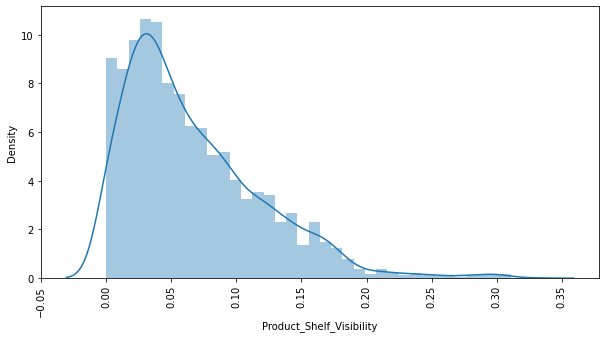

In [252]:
plt.figure(figsize=(10,5))
sns.distplot(X["Product_Shelf_Visibility"])
#rotate label if too long
plt.xticks(rotation=90)
plt.show()

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

# Model

I am proposing 3 algorithms:
* Linear Resressor
* DecisionTree Regressor and
* Random Forest Regressor 
* ExtraTree Regressor
* Random Forest Regressor
* Gradient Boosting Regressor
* Xtreme Gradient Boosting	
* Neural Network	<br>

from which the best model will be selected

For better evaluation, we'll be using Cross-Validation:

## Linear Regression Model

In [254]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in naira)')
    plt.ylabel('Proportion of Products')
    plt.legend()

    plt.show()
    plt.close()

In [255]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    
    #training data 
    #testing data 
    # lr:  linear regression object 
    #poly_transform:  polynomial transformation object 
 
    xmax=max([xtrain.values.max(), xtest.values.max()])

    xmin=min([xtrain.values.min(), xtest.values.min()])

    x=np.arange(xmin, xmax, 0.1)


    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()

In [256]:
# Fit the linear model
lre=LinearRegression()
results = lre.fit(X_train,y_train)
print(results)

LinearRegression()


In [257]:
# Print the coefficients
print (results.intercept_, results.coef_)

9132569287176418.0 [-2.71254583e+01 -7.13649310e+02  8.82484317e+03 -3.79502987e+15
 -3.79502987e+15 -3.79502987e+15 -3.79502987e+15 -3.79502987e+15
 -3.79502987e+15 -3.79502987e+15 -3.79502987e+15 -3.79502987e+15
 -3.79502987e+15 -3.79502987e+15 -3.79502987e+15 -3.79502987e+15
 -3.79502987e+15 -3.79502987e+15 -3.79502987e+15 -2.05098209e+15
 -2.05098209e+15 -2.05098209e+15  2.06246194e+15  2.06246194e+15
  2.06246194e+15 -5.34901927e+15 -5.34901927e+15 -5.34901927e+15
 -5.34901927e+15]


In [258]:
print("train score:", lre.score(X_train,y_train))

print("test score:", lre.score(X_test,y_test))

train score: 0.5567631629208285
test score: 0.5594024666325306


In [259]:
lre2 = sm.OLS(y_train, X_train)
results2 = lre2.fit()
# Statsmodels gives R-like statistical output
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     149.1
Date:                Fri, 19 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:23:45   Log-Likelihood:                -28140.
No. Observations:                2993   AIC:                         5.633e+04
Df Residuals:                    2967   BIC:                         5.649e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Product_Weight                        -26.4701    193.494     -0.137      0.891    -405.867     352.927
Product_Shelf_Visibility             -716.6102    352.334     -2.034      0.042   -1407.453     -25.767
Product_Price                        8821.8359    346.777     25.439      0.000    8141.888    9501.784
Product_Type_Baking Goods               0.2637    208.560      0.001      0.999    -408.673     409.200
Product_Type_Breads                  -248.6158    295.909     -0.840      0.401    -828.823     331.592
Product_Type_Breakfast                -63.9440    424.434     -0.151      0.880    -896.160     768.272
Product_Type_Canned                    91.2765    195.753      0.466      0.641    -292.550     475.103
Product_Type_Dairy                   -256.5026    206.297     -1.243      0.214    -661.002     147.997
Product_Type_Frozen Foods             109.7384    184.585      0.595      0.552    -252.189     471.666
Product_Type_Fruits and Vegetables    262.0497    151.236      1.733      0.083     -34.488     558.587
Product_Type_Hard Drinks              -20.5937    323.638     -0.064      0.949    -655.171     613.984
Product_Type_Health and Hygiene      -152.0829    224.123     -0.679      0.497    -591.536     287.370
Product_Type_Household               -197.1269    166.218     -1.186      0.236    -523.041     128.787
Product_Type_Meat                      18.1185    227.273      0.080      0.936    -427.511     463.748
Product_Type_Others                  -310.7060    377.694     -0.823      0.411   -1051.275     429.863
Product_Type_Seafood                  703.9602    569.992      1.235      0.217    -413.660    1821.580
Product_Type_Snack Foods               42.0077    150.146      0.280      0.780    -252.394     336.409
Product_Type_Soft Drinks              -85.3506    237.121     -0.360      0.719    -550.289     379.588
Product_Type_Starchy Foods            323.5387    400.604      0.808      0.419    -461.951    1109.028
Supermarket _Size_High              -1633.6966    341.707     -4.781      0.000   -2303.704    -963.689
Supermarket _Size_Medium              831.2637    109.932      7.562      0.000     615.713    1046.814
Supermarket _Size_Small              1018.4640    150.780      6.755      0.000     722.820    1314.108
Supermarket_Location_Type_Cluster 1  -728.0603    210.311     -3.462      0.001   -1140.431    -315.690
Supermarket_Location_Type_Cluster 2  -534.9412    261.339     -2.047      0.041   -1047.366     -22.517
Supermarket_Location_Type_Cluster 3  1479.0326    161.509      9.158      0.000    1162.352    1795.713
Supermarket_Type_Grocery Store      -4357.8670    155.870    -27.958      0.000   -4663.492   -4052.242
Supermarket_Type_Supermarket Type1   1632.3347    173.862      9.38

* Here the Ordinary Least Squares (OLS) method has given the r^2 value of 0.557 which is above average but still poor for model to be predicted on these variables. The higher (closer to one) the better.

In [261]:
print('The mean square error of price and predicted value using multifit is: ', \
      mean_squared_error(y_train, lre.predict(X_train)))

print('The mean square error of price and predicted value using multifit is: ', \
      mean_squared_error(y_test, lre.predict(X_test)))

The mean square error of price and predicted value using multifit is:  8589898.856294755
The mean square error of price and predicted value using multifit is:  9507257.271002539


C:\Users\DeleLinus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\DeleLinus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


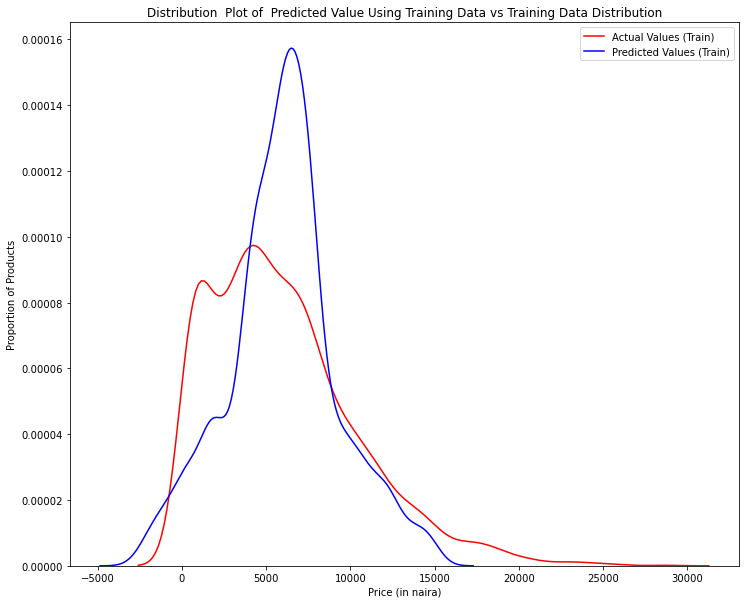

In [262]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, lre.predict(X_train), "Actual Values (Train)", "Predicted Values (Train)", Title)

In [263]:
yhat_test=lre.predict(X_test)
yhat_test[:5]

array([14926.,   124.,  2726.,  -998.,  6758.])

C:\Users\DeleLinus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\DeleLinus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


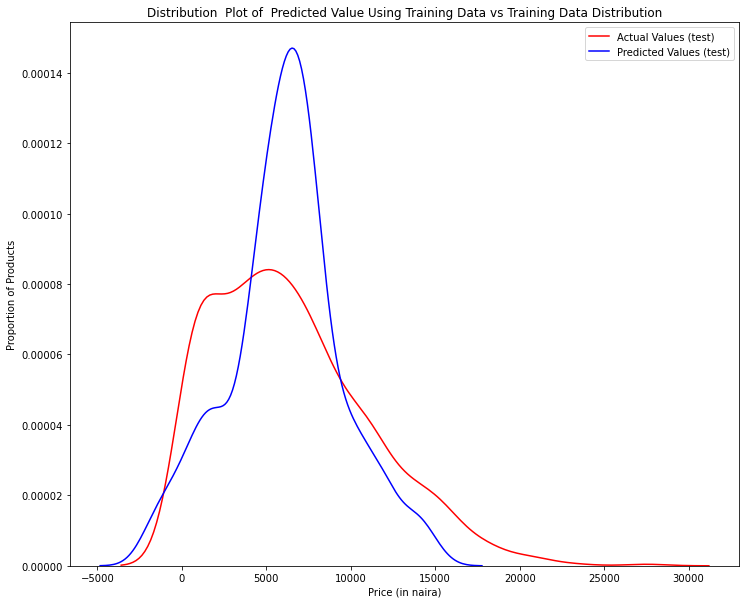

In [264]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_test, lre.predict(X_test), "Actual Values (test)", "Predicted Values (test)", Title)

**Using Cross validation**
* R^2 value is basically dependant on the way the data is split. Hence, there may be times when the R^2 value may not be able to represent the model's ability to generalize. For this we perform cross validation.

In [265]:
lre=LinearRegression()
Rcross = cross_val_score(lre, X_scaled, y, cv=5)
Rcross

print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

rc=cross_val_score(lre, X_scaled, y, cv=4,scoring='neg_mean_squared_error')
rc

The mean of the folds are 0.5519293377802535 and the standard deviation is 0.025799316279967534


array([-9212802.17754359, -8915912.61166138, -9494408.32067818,
       -7863440.49679572])

**Regularization**
* Rregularization helps to alter the loss function to penalize it for having higher coefficients for each feature variable (large coefficients leads to overfitting).

In [266]:
ridge = Ridge(alpha=0.001, normalize = True)
ridge.fit(X_train,y_train)
ridge_pred=ridge.predict(X_test)
ridge.score(X_test,y_test)

0.5593934460747929

## DecisionTree Regressor

In [267]:
dtree = DecisionTreeRegressor(max_depth=10,min_samples_leaf=5,max_leaf_nodes=5)

In [268]:
dtree.fit(X_train,y_train)
y_pred=dtree.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.5269352991786305 / 1.0
MSE score =  10207837.030234888 / 0.0


In [269]:
etr = ExtraTreesRegressor()

# Choose some parameter combinations to try

parameters = {'n_estimators': [5,10,100],
              'criterion': ['mse'],
              'max_depth': [5,10,15], 
              'min_samples_split': [2,5,10],
              'min_samples_leaf': [1,5]
             }
grid_obj = GridSearchCV(etr, parameters,
                        cv=3, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
etr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
etr.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


ExtraTreesRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                    n_estimators=10)

In [270]:
y_pred = etr.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.5753803801079813 / 1.0
MSE score =  9162484.26942916 / 0.0


## Random Forest

In [271]:
RFR = RandomForestRegressor()

parameters = {'n_estimators': [5, 10, 100],
              'min_samples_leaf': [1,2,5]
             }

grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, 
                        n_jobs=-1, 
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


RandomForestRegressor(min_samples_leaf=5)

In [272]:
y_pred = RFR.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.5636086340545008 / 1.0
MSE score =  9416496.173227103 / 0.0


In [273]:
RFR = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [5,10,100],
              'criterion': ['mse'],
              'max_depth': [5,10,15], 
              'min_samples_split': [2,5,10],
              'min_samples_leaf': [1,5]
             }


#We have to use RandomForestRegressor's own scorer (which is R^2 score)

grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, 
                        n_jobs=-1, 
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


RandomForestRegressor(max_depth=5, min_samples_split=10)

In [274]:
y_pred = RFR.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.5822145143353916 / 1.0
MSE score =  9015016.643298889 / 0.0


## Gradient Boosting Regressor

In [283]:
gbr=GradientBoostingRegressor()

parameters = {'n_estimators': [5,15,150],
              'loss':['ls','huber'],
              'criterion': ['mse'],
              'max_depth': [10,15], 
              'min_samples_split': [2,5],
              'min_samples_leaf': [1,5]
             }
grid_obj = GridSearchCV(gbr, parameters,
                        cv=5, 
                        n_jobs=-1, 
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

gbr = grid_obj.best_estimator_


# Fit the best algorithm to the data. 
gbr.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GradientBoostingRegressor(criterion='mse', max_depth=10, min_samples_leaf=5,
                          n_estimators=15)

In [284]:
y_pred = gbr.predict(X_test)

print('R2 score using Gradient Boosting= ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using Gradient Boosting= ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using Gradient Boosting=  0.5274261908532631 / 1.0
MSE score using Gradient Boosting=  10197244.520995773 / 0.0


## Xtreme Gradient Boosting

In [296]:
xgb_reg = XGBRegressor(n_estimators=64,learning_rate=0.08,max_depth=4,
                     subsample=0.7, min_child_weight=2,reg_alpha=1)#**parame)

xgb_reg.fit(X_train, y_train)

C:\Users\DeleLinus\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_delta_step=0,
             max_depth=4, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=64, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [297]:
y_pred=xgb_reg.predict(X_test)
print('R2 score using XG Boost= ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using XG Boost= ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using XG Boost=  0.5722156240299222 / 1.0
MSE score using XG Boost=  9230773.689944329 / 0.0


## Neural Network

In [300]:
y_train

array([13207.81, 13851.97,  1433.13, ...,  7939.67,  9447.7 ,  1867.57])

In [302]:
# Convert data as np.array
features = np.array(X_train)
#targets = np.array(y_train.reshape(y_train.shape[0],1))
targets = np.array(y_train.reshape(y_train.shape[0],1))
features_validation= np.array(X_test)
#targets_validation = np.array(y_test.reshape(y_test.shape[0],1))
targets_validation = np.array(y_test.reshape(y_test.shape[0],1))

print(features[:10])
print(targets[:10])

[[0.17594522 0.05281717 0.84669238 0.         0.         0.
  0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  1.         0.         0.         0.         1.        ]
 [0.72313188 0.11722664 0.49287159 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         1.         0.         0.         0.         0.
  1.         0.         1.         0.         0.        ]
 [0.38969932 0.59006672 0.67499873 0.         0.         0.
  0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.         1.         0.
  0.         1.         0.         0.         0.        ]
 [0.38969932 0.13649413 0.60626349 0.         0.         0.
  0.         0.         0.         0.         

In [341]:
# Building the model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(1))

# Compiling the model
model.compile(loss = 'mse', optimizer='adam', metrics=['mse']) #mse: mean_square_error
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                960       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________


Step :  0 / 1000
94/94 [==============================] - 0s 739us/step - loss: 8373279.0000 - mse: 8373279.0000
Training MSE: 8373279.0
24/24 [==============================] - 0s 783us/step - loss: 9382947.0000 - mse: 9382947.0000
Validation MSE: 9382947.0 

Step :  250 / 1000
94/94 [==============================] - 0s 747us/step - loss: 8304181.0000 - mse: 8304181.0000
Training MSE: 8304181.0
24/24 [==============================] - 0s 769us/step - loss: 9297875.0000 - mse: 9297875.0000
Validation MSE: 9297875.0 

Step :  500 / 1000
94/94 [==============================] - 0s 746us/step - loss: 8295906.0000 - mse: 8295906.0000
Training MSE: 8295906.0
24/24 [==============================] - 0s 1ms/step - loss: 9287012.0000 - mse: 9287012.0000
Validation MSE: 9287012.0 

Step :  750 / 1000
94/94 [==============================] - 0s 730us/step - loss: 8282380.0000 - mse: 8282380.0000
Training MSE: 8282380.0
24/24 [==============================] - 0s 745us/step - loss: 9250526.0000 

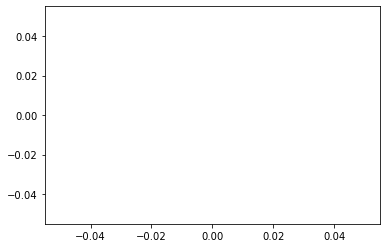

In [343]:
# Training the model
epochs_tot = 1000
epochs_step = 250
epochs_ratio = int(epochs_tot / epochs_step)
# hist =np.array([])

for i in range(epochs_ratio):
    history = model.fit(features, targets, epochs=epochs_step, batch_size=100, verbose=0)
    
    # Evaluating the model on the training and testing set
    print("Step : " , i * epochs_step, "/", epochs_tot)
    score = model.evaluate(features, targets)
    print("Training MSE:", score[1])
    score = model.evaluate(features_validation, targets_validation)
    print("Validation MSE:", score[1], "\n")
#     hist = np.concatenate((hist, np.array(history.history['mean_squared_error'])), axis = 0)

In [344]:
y_pred = model.predict(features_validation, verbose=0)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.5713002006085784 / 1.0
MSE score =  9250526.787316661 / 0.0


# Conclussion:
Using **R^2** as the evaluation metric, the following scores are gotten for the algorithms used:

| Model      | score |
| ----------- | ----------- |
| Linear Resressor | 0.559       |
| ExtraTree Regressor | 0.575    |
| Random Forest Regressor| 0.582    |
| Gradient Boosting Regressor| 0.527    |
| Xtreme Gradient Boosting| 0.572    |
| Neural Network| 582    |0.571|

* Neural network appears to perform best

# Further Improvement
* Feature interaction or engineering can be done to improve the models

# Prediction

In [348]:
sub = sample_submission.copy()
sub['Product_Supermarket_Sales'] = model.predict(df2)
sub.to_csv('NN_submission.csv', index = False)
sub.head()

39/39 [==============================] - 0s 651us/step


,Product_Supermarket_Identifier,Product_Supermarket_Sales
0,FDC15_CHUKWUDI049,5608.434082
1,NCY06_CHUKWUDI018,4197.079102
2,DRB24_CHUKWUDI035,6403.812012
3,NCG54_CHUKWUDI018,5901.750488
4,NCA42_CHUKWUDI017,6227.226074
